# Equity models

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Main functions
from src.Constants import *
from src.Utils import *

# Model simulation
from src.EquityModel import *
from src.BlackScholes import *
from src.Heston import *

from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *

## Preliminary

### Generation of 2 correlated Brownian Motions

**Remark**: We have to take into account the parameter $\rho \in \left[-1, 1\right]$ as the correlation between the two Brownian motions.

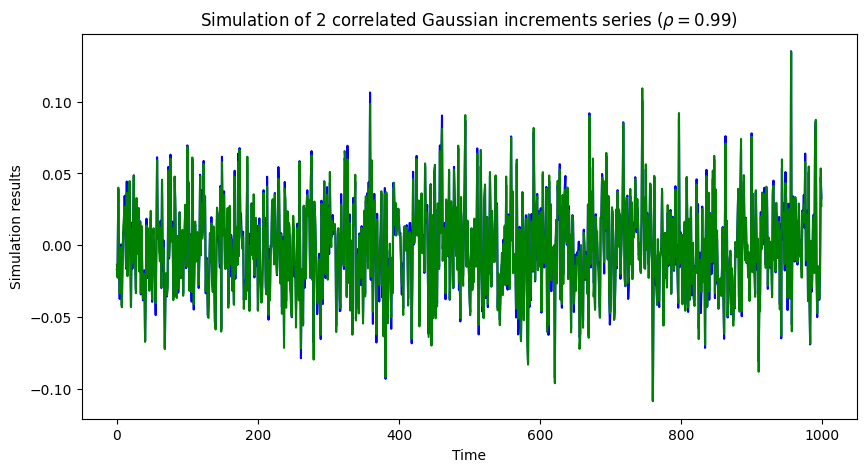

In [6]:
# Generation of Gaussian increments (Gaussian sequences)
rho_ = 0.99
for path in Utils.generate_correlated_gaussians(rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Gaussian increments series ($\rho =${rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

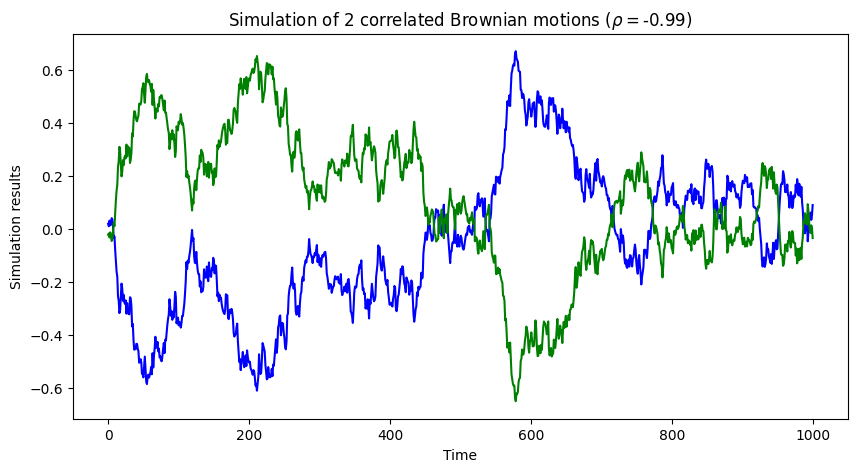

In [7]:
# Generation of Brownian motions (Cumulative sum of Gaussian increments)
for path in Utils.generate_correlated_brownians(-rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Brownian motions ($\rho =${-rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

### Generation of $k > 2$ correlated Brownian Motions

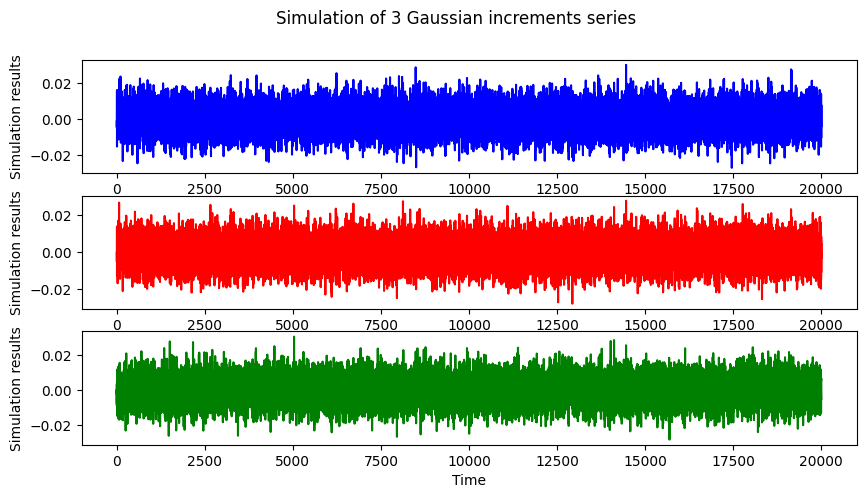

In [8]:
# Declaration of a correlation matrix
Sigma = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.7],
    [0.6, 0.7, 1]
])

colors = ["blue", "red", "green"]
# Simulation
sim_ = Utils.generate_correlated_gaussians(Sigma)
for i, path in enumerate(sim_):
    plt.subplot(len(sim_), 1, i + 1)
    _ = plt.plot(path, color=colors[i])
    _ = plt.ylabel("Simulation results")
_ = plt.suptitle(rf"Simulation of {len(Sigma)} Gaussian increments series")
_ = plt.xlabel("Time")

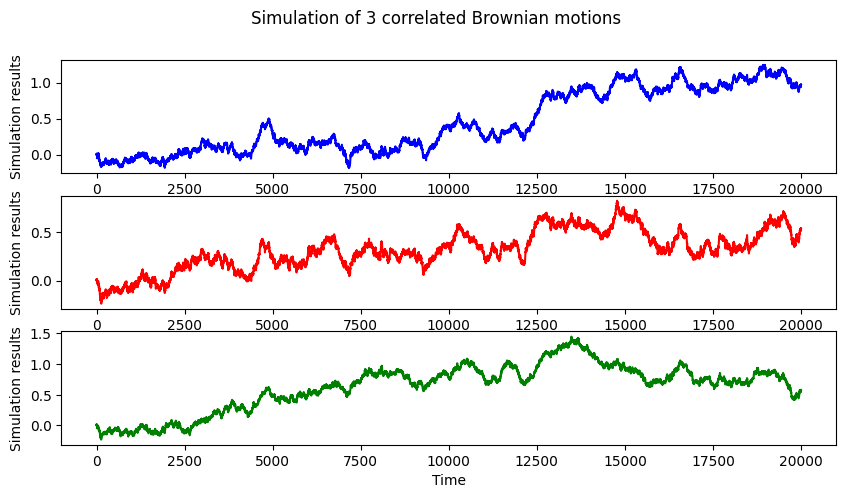

In [12]:
sim_ = Utils.generate_correlated_brownians(Sigma)
for i, path in enumerate(sim_):
    plt.subplot(len(sim_), 1, i + 1)
    _ = plt.plot(path, color=colors[i])
    _ = plt.ylabel("Simulation results")
_ = plt.suptitle(rf"Simulation of {len(Sigma)} correlated Brownian motions")
_ = plt.xlabel("Time")

## Black & Scholes

In [13]:
S0 = 1
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [14]:
model

Black-Scholes model (S0 = 1, sigma = 0.7)

In [15]:
# Simulation of 1 trajectory
d = model.simulate_euler(T=4.2, getRates=True)
df = pd.DataFrame(d)
df.head()

,t,S,r
0,0.00000,1.000000,0.400000
1,0.00021,1.004604,0.400727
2,0.00042,1.002710,0.400092
3,0.00063,1.008744,0.400131
4,0.00084,1.005100,0.399815


In [21]:
# Simulation of several trajectories
NB_TRAJECTORIES = 20
df_multi = Utils.cast_df(np.array(model.simulate_paths(M=NB_TRAJECTORIES)).T, columns = ["t"] + [f"S{k}" for k in range(1, NB_TRAJECTORIES + 1)] )
df_multi.head()

,t,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20
0,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.00005,1.000170,1.001108,1.001401,0.993820,0.988493,0.998221,1.005396,1.001655,0.996905,...,1.000933,0.999200,1.004195,0.998055,0.997457,0.986051,1.004908,1.001194,1.003419,1.000224
2,0.00010,1.000938,1.001284,0.999323,0.996715,0.985426,1.003925,1.011441,0.993024,0.991107,...,1.008070,1.000170,1.002612,1.001359,0.996765,0.990992,1.000221,1.007643,0.990318,1.003483
3,0.00015,1.003551,0.998218,0.998923,0.995369,0.987852,0.992718,1.007530,1.002602,0.987580,...,1.003052,1.006957,1.004245,1.003399,1.004438,0.997795,1.001406,1.010887,0.976113,1.001972
4,0.00020,1.000893,0.996910,1.008589,0.992684,0.990950,0.999421,1.007214,1.006029,0.986996,...,1.011287,1.007565,0.999936,1.009965,0.996549,0.994666,1.010161,1.011949,0.980280,1.001704


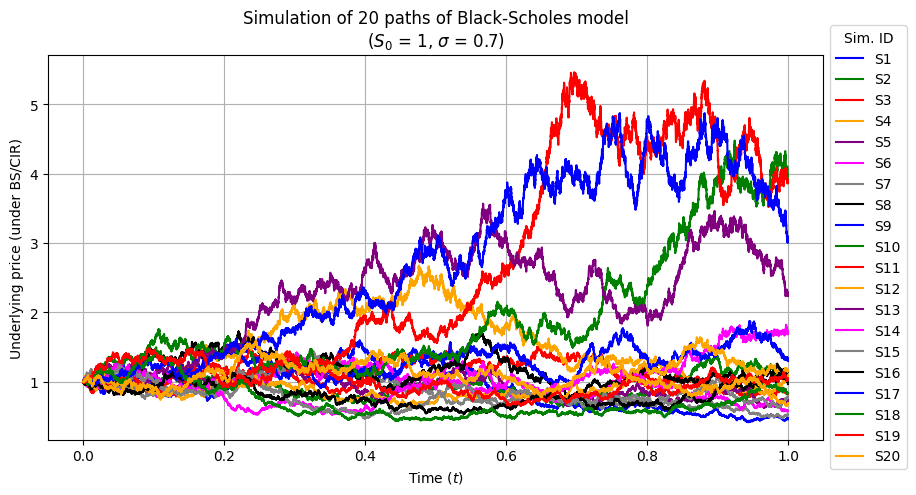

In [22]:
# Plotting the simulation paths
_ = df_multi.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Underlying price (under BS/CIR)")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Black-Scholes model\n{model.get_parameter_string()}")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Sim. ID")

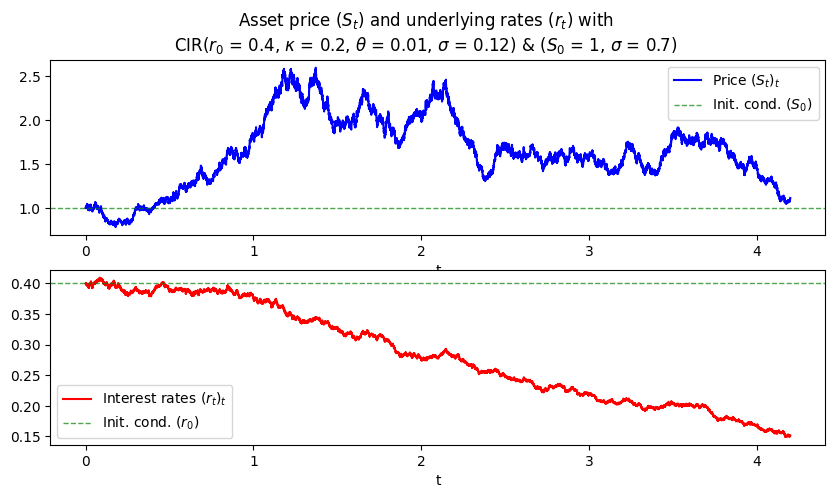

In [23]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=2, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
axes[0].legend()
axes[1].legend()
_ = plt.suptitle(f"Asset price $(S_t)$ and underlying rates $(r_t)$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

## Heston

In [24]:
# Declaring parameters
S0 = 1
V0 = 0.02
Sigma = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.7],
    [0.6, 0.7, 1]
])
sigma = 0.7
rho = 0.5
kappa = 0.20
theta = 0.02
eta = 0.06

# Declaring models (rate + equity)
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = Heston(S0, V0, r, kappa, theta, eta, Sigma) 

In [25]:
model

Heston model (S0 = 1, kappa = 0.2, theta = 0.02, eta = 0.06)

In [26]:
# Simulation of 1 trajectory
d = model.simulate_milstein(getRates=True, getVariance=True)
df = pd.DataFrame(d)
df.head()

,t,S,V,r
0,0.00000,1.000000,0.020000,0.400000
1,0.00005,1.000555,0.020055,0.400580
2,0.00010,0.998910,0.020030,0.399538
3,0.00015,0.999222,0.020099,0.399660
4,0.00020,0.999971,0.020088,0.399809


In [27]:
# Simulation of several trajectories
NB_TRAJECTORIES = 20
df_multi = Utils.cast_df(np.array(model.simulate_paths(M=NB_TRAJECTORIES)).T, columns = ["t"] + [f"S{k}" for k in range(1, NB_TRAJECTORIES + 1)] )
df_multi.head()

,t,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20
0,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.00005,0.998633,0.998719,0.999753,0.999903,0.999543,0.999307,1.001040,0.997761,0.999896,...,1.002176,1.000086,0.999517,0.998724,1.000089,1.000006,1.000257,1.000414,0.999761,0.998521
2,0.00010,0.997095,1.000540,0.999193,0.998291,1.000018,0.999103,1.001110,0.998293,1.000573,...,1.000678,0.999657,0.998544,0.998893,0.999271,1.001702,0.999984,0.999174,1.000109,0.999642
3,0.00015,0.996066,0.999724,1.000914,0.998125,0.999270,0.996765,1.001326,0.999040,1.000209,...,0.999537,1.000567,1.000698,0.999623,0.999897,1.001981,1.000864,0.998224,0.998210,1.001010
4,0.00020,0.994936,0.997833,1.000742,0.998559,1.000422,0.996577,1.001727,0.999909,0.999143,...,0.999710,1.000349,0.997979,0.999314,0.999228,1.000638,0.999716,0.998312,0.998217,1.001249


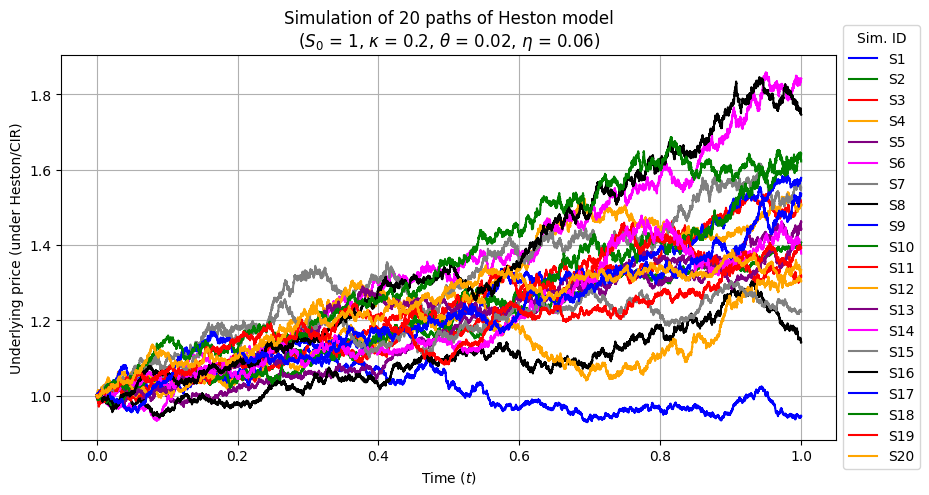

In [28]:
# Plotting the simulation paths
_ = df_multi.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Underlying price (under Heston/CIR)")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Heston model\n{model.get_parameter_string()}")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Sim. ID")

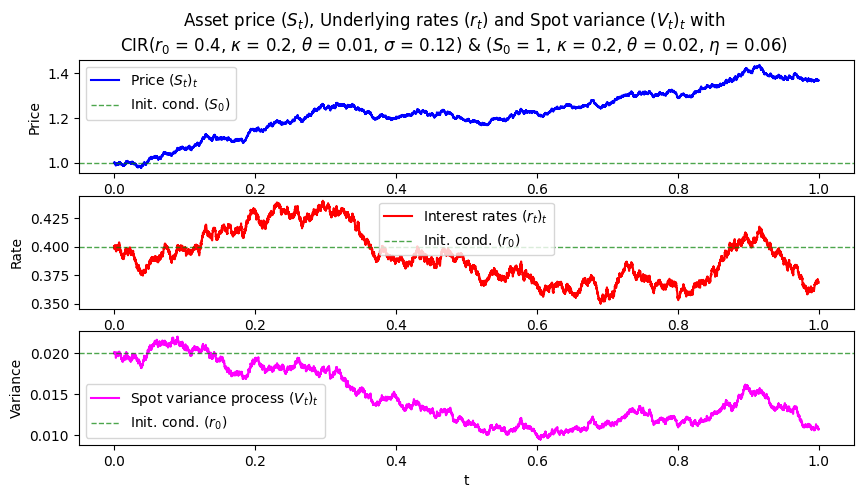

In [29]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=3, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
_ = df.plot(x = "t", y = "V", color="magenta", label="Spot variance process $(V_t)_t$", ax=axes[2])
_ = axes[2].axhline(y = model.V0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")

# Plotting options
axes[0].legend()
axes[0].set_ylabel("Price")
axes[1].legend()
axes[1].set_ylabel("Rate")
axes[2].legend()
axes[2].set_ylabel("Variance")
_ = plt.suptitle(f"Asset price $(S_t)$, Underlying rates $(r_t)$ and Spot variance $(V_t)_t$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")